<a href="https://colab.research.google.com/github/TheGodseeker/ML_PR/blob/main/%D0%97%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Методы кластеризации и оценка качества кластеризации

Загрузите набор данных из файла cluster datasets в соответствии с вашим вариантом (если считаете, что набор данных не представляет необходимой информации или сложен для интерперетации или, то можно выбрать другой - но **необходимо предварительное согласование**).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from statistics import median, mean, stdev
from math import erfc
from sklearn.cluster import DBSCAN

df = pd.read_csv("/content/anime.csv")
df.columns

Index(['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members'], dtype='object')

Используйте представленные в практике методы кластеризации (помните, что кластеры строятся по классам).

Несколько правил перед выполнением задания:
0. Внимательно изучить практику 4!
1. Служебные комментарии читать внимательно и не удалять
2. Выполнить до 10-11-2023 (но не затягивать, таск не простой!)


P.S. Мгномерные данные - данные, в которых количество колонок > 3

P.S.S. Служебные комментарии - ячейки с описанием задачи в """ task description """



In [ ]:
"""
Предварительно - оптимизируйте ваш набор данных.
1. Удалить лишние колонки (порядковые признаки, с множеством пропусков, с кучей выбросов, ....)
2. Обработайте выбросы и пропуски (Для удобства - ваш коллега сделал библиотеку в pypi для анализа выбросов - подробности уточняйте в группе)
3. Скопируйте df в df_cluster # df_cluster = df.copy()
далее вы работаете с ним
4. Выполните масштабирование числовых признаков StandatdScaler || MinMaxScaler, в df_cluser замените числовые признаки на отмасштабированные
5. Для кагегориальных значений используйте LabelEncoder - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html. В df_cluster замените на encoded признаки
"""

In [ ]:

#Класс для чистки
class Burst:
  def __init__(self, df):
    self.df = df

  #Выбросы по средней
  def bursts_by_mean(self, column_name):
    mean_data = mean(self.df[column_name])
    maximum = mean_data * 2
    result = []
    col_series = self.df[column_name] # [(index, value), (index, value)]
    cur_series_size = 0

    for index, value in col_series.items():
      if abs(value) - mean_data > maximum:
        result.append(index)

    return result

  #Выбросы по критерию Шовене
  def burst_by_shovene(self, column_name):
    col_series = self.df[column_name]
    cur_series_size = 0
    result = []
    my_mean = mean(self.df[column_name])
    my_stdev = stdev(self.df[column_name])

    for index, value in col_series.items():
      if (my_stdev > 0) and erfc(abs(value-my_mean)/my_stdev) < 1 / (2*col_series.size):
          result.append(index)

    return result
  #Выбросы по квартилям
  def burst_by_quart(self, column_name):
    col_series = self.df[column_name]
    cur_series_size = 0
    result = []
    qs = col_series.quantile([0.25,0.5,0.75])

    for index, value in col_series.items():
      if (value > qs[0.75]) or (value < qs[0.25]):
        result.append(index)

    return result

  #Выбросы по двум переменным #нужно оганизовать поиск по нескольким СТОЛБЦАМ
  def burst_by_num(self, fst, scd):
    trg = self.df.loc[:, [fst, scd]].values
    # x = self.df.loc[fst]
    # y = self.df.loc[scd]

    dbscan = DBSCAN(eps = 8, min_samples = 4).fit(trg) # fitting the model
    labels = dbscan.labels_ # getting the labels

    # plt.scatter(x[:, 0], x[:,1], c = labels, cmap= "plasma") # plotting the clusters
    # plt.xlabel(fst) # X-axis label
    # plt.ylabel(scd) # Y-axis label
    # plt.show()


In [ ]:
#Убираем лишние столбцы
df = df.drop("anime_id", axis=1)
df = df.drop("episodes", axis=1)

for i in df.columns:
  if df[i].isnull().sum() > (df.size / 3):
    df = df.drop(i, axis=1)


In [ ]:
#Удаляем пустоты и выбросы
df = df.dropna()

sel_col = [ 'rating', 'members']
burster = Burst(df)
for i in sel_col:
  if i in df.columns:
    df.drop(burster.burst_by_quart(i))

In [ ]:
#Копируем данные
df_cluster = df.copy()

In [ ]:
#Масштабируем

num_features = df_cluster.select_dtypes(include=['float64','int64']).columns

from sklearn.preprocessing import StandardScaler
# Standard масштабирование
scaler_std = StandardScaler()
df_cluster[num_features] = scaler_std.fit_transform(df_cluster[num_features])
# df_std_scaled.Score.unique() # преобразованные уникальные значения в числовом призанке в диапозоне [0, 1]


In [ ]:
#Манипуляции  с кат. значениями

from sklearn.preprocessing import LabelEncoder

sel_col = [ 'name', 'genre', 'type']

le_name = LabelEncoder()
le_name.fit(df_cluster["name"].unique())

le_genre = LabelEncoder()
le_genre.fit(df_cluster["genre"].unique())

le_type = LabelEncoder()
le_type.fit(df_cluster["type"].unique())

for i in sel_col:
  match i:
    case "name":
      df_cluster[i] = le_name.transform(df_cluster[i].values)
    case "genre":
      df_cluster[i] = le_genre.transform(df_cluster[i].values)
    case "type":
      df_cluster[i] = le_type.transform(df_cluster[i].values)

In [ ]:
"""
Здесь k-means и метрики. Используйте несколько вариантов метрик (из практики), для поиска оптимального числа кластеров.
"""

In [ ]:
# Создаем экземпляр модели K-Means
X = df_cluster [['members', 'rating']]

kmeans = KMeans(n_clusters=8)

# Производим кластеризацию данных
kmeans.fit(X)

# Получаем центры кластеров и прогнозируем принадлежность к кластерам
cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
kmeans_2 = KMeans(n_clusters=16)

# Производим кластеризацию данных
kmeans_2.fit(X)

# Получаем центры кластеров и прогнозируем принадлежность к кластерам
cluster_centers_2 = kmeans_2.cluster_centers_
cluster_labels_2 = kmeans_2.labels_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
"""
Здесь визуализация кластеров k-means
(Для многомерных данных используйте сжатие методами (на выбор один из) PCA/t-TSNE/umap до 2,3 точек - влияет на вид гарфика, если 2 точки - то двумерный, если три точки - то трехмерный)
"""

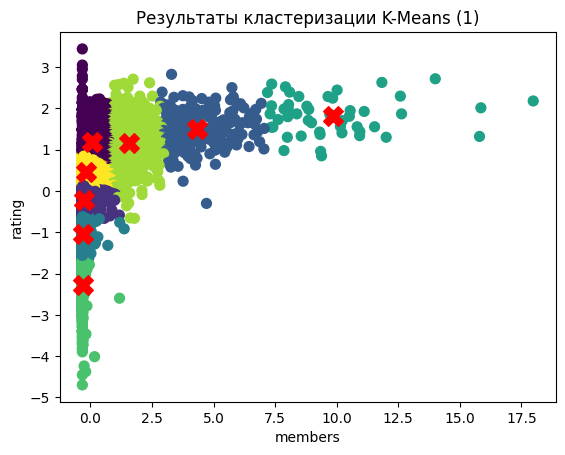

In [ ]:
# Визуализируем результаты кластеризации двумерной кластеризации
plt.scatter(df_cluster['members'], df_cluster['rating'], c=cluster_labels, s=50, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=200, marker='X')
plt.xlabel('members')
plt.ylabel('rating')
plt.title('Результаты кластеризации K-Means (1)')
plt.show()

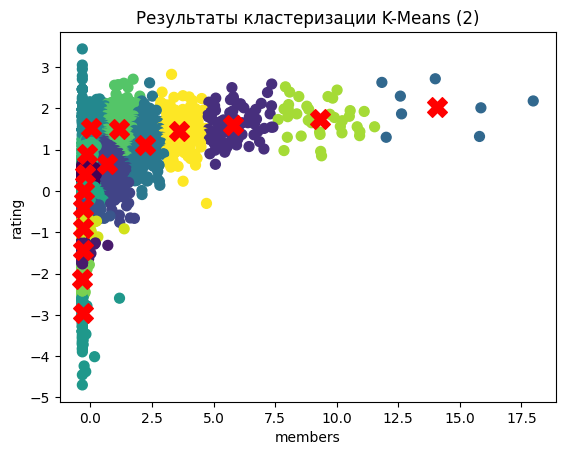

In [ ]:
# Визуализируем результаты кластеризации
plt.scatter(df_cluster['members'], df_cluster['rating'], c=cluster_labels_2, s=50, cmap='viridis')
plt.scatter(cluster_centers_2[:, 0], cluster_centers_2[:, 1], c='red', s=200, marker='X')
plt.xlabel('members')
plt.ylabel('rating')
plt.title('Результаты кластеризации K-Means (2)')
plt.show()

In [ ]:
"""
Здесь DBSCAN и метрики. Используйте поиск оптимального EPS. Объясните почему?
"""

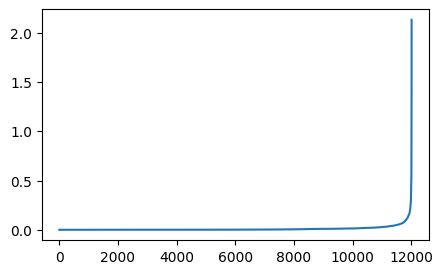

In [ ]:
#Находим eps
from sklearn.neighbors import NearestNeighbors # importing the library
neighb = NearestNeighbors(n_neighbors=2) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(X) # fitting the data to the object
distances,indices=nbrs.kneighbors(X)

distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.show() # showing the plot

Опираясь на график, можно сказать, что eps=0.25

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

x_scaler = StandardScaler().fit_transform(X)

# Инициализация и обучение модели DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=16)
dbscan.fit(x_scaler)

# Получение меток кластеров для каждой точки (-1 означает выбросы)
labels = dbscan.labels_

In [ ]:
"""
Здесь визуализация кластеров DBSCAN
(Для многомерных данных используйте сжатие методами (на выбор один из) PCA/t-TSNE/umap до 2,3 точек - влияет на вид гарфика, если 2 точки - то двумерный, если три точки - то трехмерный)
"""

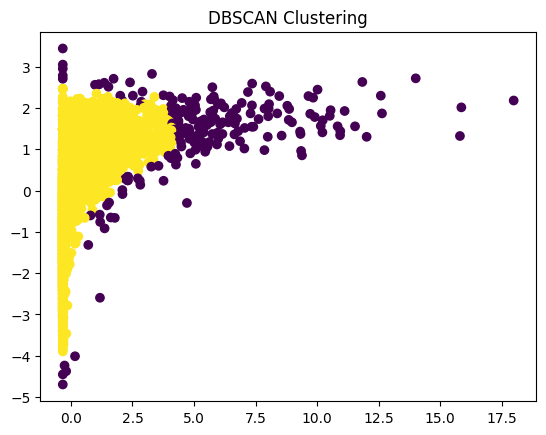

In [ ]:
# Визуализация результатов, темные точки - выбросы
plt.scatter(X.to_numpy()[:, 0], X.to_numpy()[:, 1], c=labels, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.show()

In [ ]:
"""
Здесь иерархическая кластеризация и метрики
"""

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# Инициализация и обучение модели иерархической кластеризации
agg_clustering = AgglomerativeClustering(n_clusters=4)
agg_clustering.fit(X)

AgglomerativeClustering(n_clusters=4)

In [ ]:
"""
Здесь визуализация кластеров иерархической кластеризации
(Для многомерных данных используйте сжатие методами (на выбор один из) PCA/t-TSNE/umap до 2,3 точек - влияет на вид гарфика, если 2 точки - то двумерный, если три точки - то трехмерный)
"""

In [ ]:
# Визуализация дендрограммы
from scipy.cluster import hierarchy
linkage_matrix = hierarchy.linkage(X, method='ward')
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

In [ ]:
# Визуализация результатов кластеризации
plt.scatter(X.to_numpy()[:, 0], X.to_numpy()[:, 1], c=agg_clustering.labels_, cmap='viridis')
plt.title('Agglomerative Clustering')
plt.show()

In [ ]:
!pip install ydata-profiling

Выполните профилирование набора данных относительно кластеров, используя оригинальный набор данных.

P.S. задание для всех

In [ ]:
#
#### Приветсвуется ручной анилиз - гарфики, статистика по разным кластерам, как альтернативный путь решения задачи
#

# 1. в оригинальный набор данных добавьте колонки с кластерами и работаем с ним

"""
df['kmeans_cluster'] = kmeans_cluster.labels_
df['dbsscan_cluster'] = dbsscan_cluster.labels_
...
"""

# 2. Выполните фильтрацию относительно каждого кластера и каждого алгоритма (Внимание, кластер -1 не учитываем в DBSSCAN, тк это выбросы. То есть, точки не вошли ни в одни кластер)
"""
P.S за пример взять 1 тип кластеров, выполните для всех (если кластеров больше 3, разрешено использовать первые три кластера для анализа)

from ydata_profiling import ProfileReport
df['dbscan_labels'] = dbscan.labels_

uniq_labels = tuple(set(dbscan.labels_))

print(uniq_labels)

"""

# 3. Выполните профилирование
"""
На отдельной ячейке выполните профилирование для каждого кластера и каждого алгоритма

from ydata_profiling import ProfileReport

ProfileReport(df[df.dbscan_labels == 0]) # фильтруем по кластерам из uniq_labels, получаем красивый результат :)

"""

# 4. Проанализируйте результат по кластерам. Какие переменные попали в каждый кластер, их различия (статистические), графики.
# Постарайтесь объяснить различия "фактически".
# Например, видно, что в кластер 1 у пациентов возраст выше в среднем и в медиане, чем в остальных, что может свидетельствоать о влиянии возраста на кластер №()



In [ ]:
df['kmeans_cluster'] = cluster_labels_2
df['dbsscan_cluster'] = labels

In [ ]:
#df['dbscan_labels'] = dbscan.labels_

df["kmeans_labels"] = cluster_labels_2
uniq_labels = tuple(set(cluster_labels_2))

print(uniq_labels)

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)


In [ ]:
from ydata_profiling import ProfileReport

ProfileReport(df[df.dbscan_labels == 0]) # фильтруем по кластерам из uniq_labels, получаем красивый результат :)

ImportError: ignored